Contents

On Linear Regression

Linear regression intro
    Linear regression problem actually is least squares problem

Exact solutions to the least squares problem

    Normal equation
        Short derivation (mlzoomcamp course)
        Formal derivation (formal)
        Limitation = numerical instability/ill-conditioned meaning (rank deficiency) and large datasets, typically not used under the hood of common libraries such as Numpy or sklearn (refer to LAPACK and other traditional linear algebra libraries)

    SVD
        Derivation
        Better than solving normal equation directly, since it is numerically stable (explain why)
        Limitation = large datasets
        Used in sklearn (point to code on GH)

    QR
        Derivation
        Better than solving normal equation directly, since it is numerically stable (explain why)
        Limitation = large datasets
        Used in sklearn (point to code on GH)

    Regularization
        Multicollinearity (linearly dependent columns)
        Insufficient data (wide and short matrix)
         
    Ridge regression
    Lasso
    ElasticNet
    PCA as a form of regularization (?)

    Iterative solutions
        Gradient Descent
        SGD



Simple short sentences, ELI5 tldr in cursive at the beginning
Expand code

# On Linear Regression

## 1. Linear Regression is a Least Squares Problem

**Linear regression** is a method to model the relationship between a dependent variable and one or more independent variables using a straight line. It's widely used in various fields.

In this post, we'll walk through **linear regression**, show how it's connected to the **least squares problem**, and explain how we can find the best linear model by minimizing the **Sum of Squared Errors**.

Let's start by considering a simple linear relationship. Imagine we have a dataset where the relationship between $x$ and $y$ follows this equation:
$$
y = 1 + 2 x
$$

To visualize this relationship, we plot a few points.

Text(0, 0.5, 'y')

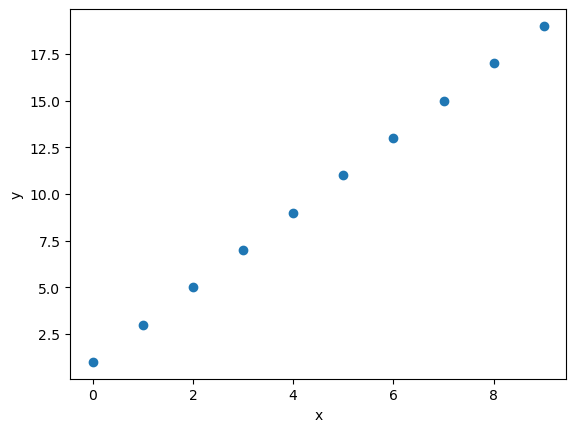

In [60]:
import numpy as np
import matplotlib.pyplot as plt


x = np.arange(0, 10, 1)
y = 1 + 2*x

plt.scatter(x, y)
plt.xlabel("x")
plt.ylabel("y")

In real-world scenarios, we typically don't know the exact relationship. Instead, we are given data points, and the goal is to find the best line that fits this data. 

Let's take a look at our data:

In [118]:
# x and y coordinates
for a, b in zip(x, y):
    print(f"({a}, {b})")

(0, 1)
(1, 3)
(2, 5)
(3, 7)
(4, 9)
(5, 11)
(6, 13)
(7, 15)
(8, 17)
(9, 19)


Linear regression helps us to find the weights $w_0$ and $w_1$ in the linear equation $y=w_0 + w_1 x$. These weights define the relationship between $x$ and $y$. 

However, normally we don't know $w_0$ and $w_1$ a-priori. So how do we find out? 

Let's take a random guess. The function below takes in a guess for the weights $w_0$ and $w_1$ and returns y.

In [52]:
def calculate_y(w_0, w_1):
    y = w_0 + w_1 * x
    return y

Let's guess that $w_0=8$ and $w_1=-1$:

$$
\hat y = 8 - 1 x
$$

*Note that we will denote our prediction for $y$ by a hat symbol: $\hat y$.*

This relationship is visualized below by the red line.

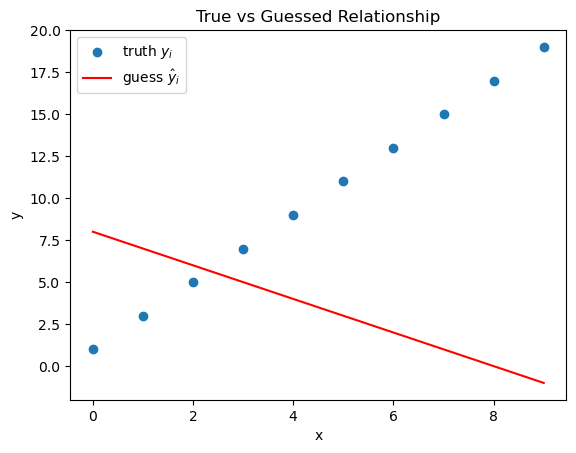

In [134]:
y_guess = calculate_y(8, -1)

plt.scatter(x, y, label="truth $y_i$")
plt.plot(x, y_guess, label="guess $\hat y_i$", color="red")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("True vs Guessed Relationship");

Our guess is far off from the truth. How can we quantify how far off it is? This is where **residuals** come in. A **residual** is the difference between the true value of $y$ and the predicted value $\hat{y}$. For each data point, we can compute the residual as:
$$
{residual}_{i} = y_i - \hat y_i
$$

Let's calculate the residuals and visualize them:

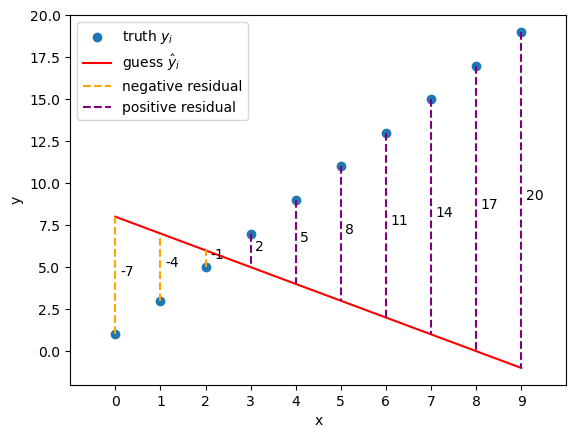

In [135]:
# Calculate the residuals
residuals = y - y_guess

# Visualize the residuals
plt.scatter(x, y, label="truth $y_i$")
plt.plot(x, y_guess, label="guess $\hat y_i$", color="red")
for i, _ in enumerate(y):
    color = "orange" if residuals[i] < 0 else "purple"
    label = "negative residual" if i==0 else ("positive residual" if i==len(y)-1 else None)
    plt.plot((x[i], x[i]), (y[i], y_guess[i]), linestyle="--", color=color, label=label)
    plt.text(x[i] + 0.1, y[i] - residuals[i]/2, s=residuals[i])
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.xticks(x);
plt.xlim((-1, 10));

The dashed lines in the plot represent the **residuals** for each data point, and the numbers next to them indicate the size of the residual. Negative residuals (yellow) show that the predicted value is greater than the actual value, while positive residuals (purple) indicate the opposite.

Our goal is to minimize the residuals to find the best fitting line. But how can we achieve that?

One approach could be to calculate the sum of the residuals for the M data points we have and find $w_0$ and $w_1$ that minimize this sum:

$$
\sum_i^M {(y_i - \hat y_i)} = \sum_i^M({y_i - (w_0 + w_1 x_i))}
$$

However, as shown in the plot above, some residuals are positive, while others are negative. If we simply sum them, the positive and negative residuals could cancel each other out, misleading us into thinking we have a good fit when we don't. To avoid this, we **square the residuals** before summing them:

$$
SSE = \sum_i^M{(y_i - \hat y_i)^2} = \sum_i^M{(y_i - (w_0 + w_1 x_i))^2}
$$

*Note that **SSE** stands for **Sum of Squared Errors**. Error is synonymous to residual.*

Let's visualize the **SSE**:

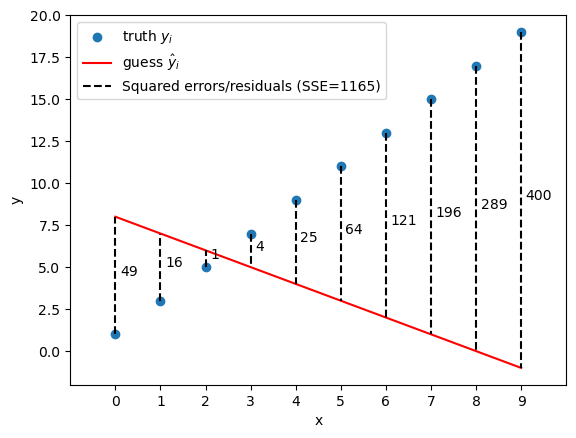

In [137]:
# SSE
residuals_squared = (y - y_guess) ** 2

plt.scatter(x, y, label="truth $y_i$")
plt.plot(x, y_guess, label="guess $\hat y_i$", color="red")
for i, _ in enumerate(y):
    plt.plot((x[i], x[i]), (y[i], y_guess[i]), linestyle="--", color="black", label=f"Squared errors/residuals (SSE={residuals_squared.sum()})" if i==0 else None)
    plt.text(x[i] + 0.1, y[i] - residuals[i]/2, s=residuals_squared[i])
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.xticks(x);
plt.xlim((-1, 10));


Squaring ensures that any deviation between our predictions and the actual values, whether positive or negative, is penalized. Additionally, squaring the residuals gives us a **differentiable function**, allowing for a **closed-form solution** to this **Least Squares Problem**, which we will explore shortly.

## 2. Solving the Least Squares Problem

Let's now find a way to determine the weights to come up with a prediction $\hat y$ which minimizes the **SSE**. First, however, we will generalize the problem $M$ equations and $N$ features/dimensions.

### Generalizing the Least Squares Problem

Up to this point, we've considered only the two-dimensional case:

$$
y_i = w_0 + w_1 x_{i}
$$

This helps with visualizing the problem at hand. However, we can generalize the formulation to any number of dimensions $N$. In the multi-dimensional case, instead of a single predictor $x_1$, we now have multiple predictors $x_{i1}, x_{i2}, \dots, x_{iN}$. Each of these predictors has an associated weight $w_1, w_2, \dots, w_N$.

The multi-dimensional form of the model becomes:

$$
y_i = w_0 + w_1 x_{i1} + w_2 x_{i2} + \dots + w_N x_{iN}
$$

We can write this more compactly as the following dot product:

$$
y_i = \mathbf{x}_i^T \mathbf{w}
$$

Where:
$$
\mathbf{x}_i = \begin{bmatrix} 1 \\ x_{i1} \\ x_{i2} \\ \vdots \\ x_{iN} \end{bmatrix}, 
\mathbf{w} = \begin{bmatrix} w_0 \\ w_1 \\ w_2 \\ \vdots \\ w_N \end{bmatrix}
$$

Next, we will rewrite the equation in matrix form. Consider that we have $M$ data points:

$$
y_1 = \mathbf{x}_1^T \mathbf{w} \\
y_2 = \mathbf{x}_2^T \mathbf{w} \\
\vdots \\
y_i = \mathbf{x}_M^T \mathbf{w}
$$

As a matrix equation this becomes:

$$
\begin{bmatrix} 
y_1 \\ 
y_2 \\ 
\vdots \\ 
y_M 
\end{bmatrix} =
\begin{bmatrix} 
\mathbf{x}_1^T \mathbf w\\
\mathbf{x}_2^T \mathbf w\\ 
\vdots \\
\mathbf{x}_M^T \mathbf{w} \\ 
\end{bmatrix} =
\begin{bmatrix} 
\mathbf{x}_1^T \\
\mathbf{x}_2^T \\ 
\vdots \\
\mathbf{x}_M^T 
\end{bmatrix} \mathbf w
$$

Or, more succinctly:

$$
\mathbf y = \mathbf{X} \mathbf{w}
$$

Where:
$$
\mathbf X = 
\begin{bmatrix} 
\mathbf{x}_1^T \\
\mathbf{x}_2^T \\ 
\vdots \\
\mathbf{x}_M^T 
\end{bmatrix} =
\begin{bmatrix} 
1 && x_{11} && x_{12} && ... && x_{1N} \\
1 && x_{21} && x_{22} && ... && x_{2N} \\
\vdots && \vdots && \vdots && \ddots && \vdots \\
1 && x_{M1} && x_{M2} && ... && x_{MN}
\end{bmatrix}
$$

### Solving the Least Squares Problem

There are different ways to perform Linear Regression by solving the Least Squares Problem. This section will explore various ways.

#### Solution 1: Normal Equation

The **Sum of Squared Errors** for this generalized form is:

$$
SSE = {(\mathbf{y} - \mathbf{X} \mathbf{w})^T (\mathbf{y} - \mathbf{X} \mathbf{w})}
$$

This expands to:

$$
SSE = (\mathbf{y}^T - \mathbf{w}^T \mathbf{X}^T) (\mathbf{y} - \mathbf{X} \mathbf{w}) =
\mathbf{y}^T \mathbf{y} \underbrace{- \mathbf{y}^T \mathbf{X} \mathbf{w} - \mathbf{w}^T \mathbf{X}^T \mathbf{y}}_{\text {equal terms}} + \mathbf{w}^T \mathbf{X}^T \mathbf{X} \mathbf{w} = 
\mathbf{y}^T \mathbf{y} - 2 \mathbf{y}^T \mathbf{X} \mathbf{w} + \mathbf{w}^T \mathbf{X}^T \mathbf{X} \mathbf{w}
$$

Note that in the last expression, the middle two terms are scalars with the same magnitude. Therefore we combine them.

We have to find $\mathbf w$ such that $SSE$ is minimized. To that end we will take the derivative of $SSE$ with respect to $\mathbf w$ and set it equal to 0:

$$
\frac {\partial SSE} {\partial \mathbf w} = 
\frac {\partial} {\partial \mathbf w} ( \mathbf{y}^T \mathbf{y} - 2 \mathbf{y}^T \mathbf{X} \mathbf{w} + \mathbf{w}^T \mathbf{X}^T \mathbf{X} \mathbf{w} ) = 0
$$

$$
\frac {\partial SSE} {\partial \mathbf w} = 
- 2 \mathbf{y}^T \mathbf{X}  + 2 \mathbf{w}^T \mathbf{X}^T \mathbf{X} = 0
$$



The Least Squares Problem can be formulated as follows:

$$
\min_{\mathbf w} {(\mathbf{y} - \mathbf{X} \mathbf{w})^T (\mathbf{y} - \mathbf{X} \mathbf{w})}
$$


This is equivalent to the magnitude of the vector squared. It can be written more compactly using the Euclidian (i.e. $l_2$) norm notation:

$$
SSE = \|\mathbf{y} - \mathbf{X} \mathbf{w}\|_2^2
$$



### Normal Equation: Intuition

Now, let's look at our linear model:

$$
\mathbf{\hat{y}} = \mathbf{X} \mathbf{w}
$$

If $\mathbf{X}$ were invertible, we could solve for $\mathbf{w}$ by left-multiplying by $\mathbf{X}^{-1}$:

$$
\mathbf{w} = \mathbf{X}^{-1} \mathbf{y}
$$

However, $\mathbf{X}$ is typically not square and thus not invertible. To address this, we left-multiply by the transpose $\mathbf{X^T}$:

$$
\mathbf{X}^T \mathbf{X} \mathbf{w} = \mathbf{X}^T \mathbf{y}
$$

This forms the Gram Matrix $\mathbf{X}^T \mathbf{X}$, which is usually invertible.

$$
\underbrace{\mathbf{X}^T \mathbf{X}}_{\text{Gram Matrix}} \mathbf{w} = \mathbf{X}^T \mathbf{y}
$$

Since the  Gram matrix  does have an inverse, we can left-multiply by it:

$$
(\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{X} \mathbf{w} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}
$$

We can simplify this:

$$
\underbrace{(\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{X}}_{I} \mathbf{w} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}
$$

$$
\mathbf{w} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}
$$

This equation finds the $\mathbf{w}$ which minimizes the sum of squared errors between the data and the model.

### Normal Equation: Formal Derivation